<a href="https://colab.research.google.com/github/Owen19920902/DS/blob/main/carbon_LLm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd

# ------------ ticker 与变量名映射 ------------
tickers = [
    "BZ=F", "CL=F", "NG=F", "TTF=F", "MTF=F",
    "EURUSD=X", "DX=F", "^STOXX50E", "^GDAXI", "^GSPC", "^VIX",
    "CARB.L", "GRN", "KCCA", "KEUA", "ICLN",
    "RWE.DE", "MT", "HEI.DE", "ORSTED.CO", "VWS.CO",
    "HG=F", "HYG", "EEM", "^BCOM"
]

names = {
    "BZ=F": "Brent_Oil",
    "CL=F": "WTI_Oil",
    "NG=F": "Natural_Gas",
    "TTF=F": "Dutch_Gas",
    "MTF=F": "Thermal_Coal",
    "EURUSD=X": "EUR_USD",
    "DX=F": "Dollar_Index",
    "^STOXX50E": "EURO_Stoxx50",
    "^GDAXI": "DAX",
    "^GSPC": "SP500",
    "^VIX": "VIX",
    "CARB.L": "EUA_Price",
    "GRN": "EUA_Price_Alt",
    "KCCA": "Calif_EUA",
    "KEUA": "EU_EUA",
    "ICLN": "Clean_Energy",
    "RWE.DE": "RWE_Utility",
    "MT": "Mittal_Steel",
    "HEI.DE": "Heidelberg_Cement",
    "ORSTED.CO": "Orsted",
    "VWS.CO": "Vestas",
    "HG=F": "Copper",
    "HYG": "HighYield_Bond",
    "EEM": "Emerging_ETF",
    "^BCOM": "Bloomberg_Comm"
}

# ------------ 时间范围 ------------
start_date = "2020-01-01"
end_date = "2024-12-31"

# ------------ 下载数据（周频）------------
print("📥 正在下载数据，请稍候...")
df_raw = yf.download(tickers, start=start_date, end=end_date, interval='1wk', group_by='ticker', progress=False)

# ------------ 提取收盘价并重命名列名 ------------
df_close = pd.DataFrame()
for t in tickers:
    try:
        df_close[names[t]] = df_raw[t]['Close']
    except Exception as e:
        print(f"⚠️ 无法获取 {t}: {e}")

# ------------ 缺失值处理：前向填充 + 删除残缺行 ------------
df = df_close.ffill().dropna()

# ------------ 保存为 CSV 文件 ------------
output_path = "Macro_Market_Expanded_EUA_Weekly_2020_2024.csv"
df.to_csv(output_path, index=True)
print(f"✅ 数据已保存为：{output_path}")
print("📊 共计行数（周数）：", df.shape[0], "；列数（变量数）：", df.shape[1])

# ------------ 数据预览 ------------
print(df.head())


📥 正在下载数据，请稍候...
YF.download() has changed argument auto_adjust default to True
✅ 数据已保存为：Macro_Market_Expanded_EUA_Weekly_2020_2024.csv
📊 共计行数（周数）： 339 ；列数（变量数）： 25
            Brent_Oil    WTI_Oil  Natural_Gas   Dutch_Gas  Thermal_Coal  \
Date                                                                      
2021-10-04  82.559998  78.930000        6.312  116.019997    274.000000   
2021-10-06  83.419998  80.639999        5.505   85.697998    243.149994   
2021-10-11  83.419998  80.639999        5.505   85.697998    243.149994   
2021-10-13  85.080002  82.959999        5.088   89.931999    237.000000   
2021-10-18  85.080002  82.959999        5.088   89.931999    237.000000   

             EUR_USD  Dollar_Index  EURO_Stoxx50           DAX        SP500  \
Date                                                                          
2021-10-04  1.161845     93.967003   4073.290039  15206.129883  4345.720215   
2021-10-06  1.155375     94.518997   4073.290039  15206.129883  4350.6499


Top 5 Features for EUA_Price: ['EUA_Price_Alt', 'Dollar_Index', 'HighYield_Bond', 'DAX', 'Emerging_ETF']
✅ Top 5 features saved to LASSO_Top5_Features.csv

📊 Model Evaluation:
▶ MSE  : 2.9362
▶ RMSE : 1.7135
▶ MAE  : 1.2694
✅ Prediction results saved to: /content/XGBoost_LASSO_Top_5_Features.csv


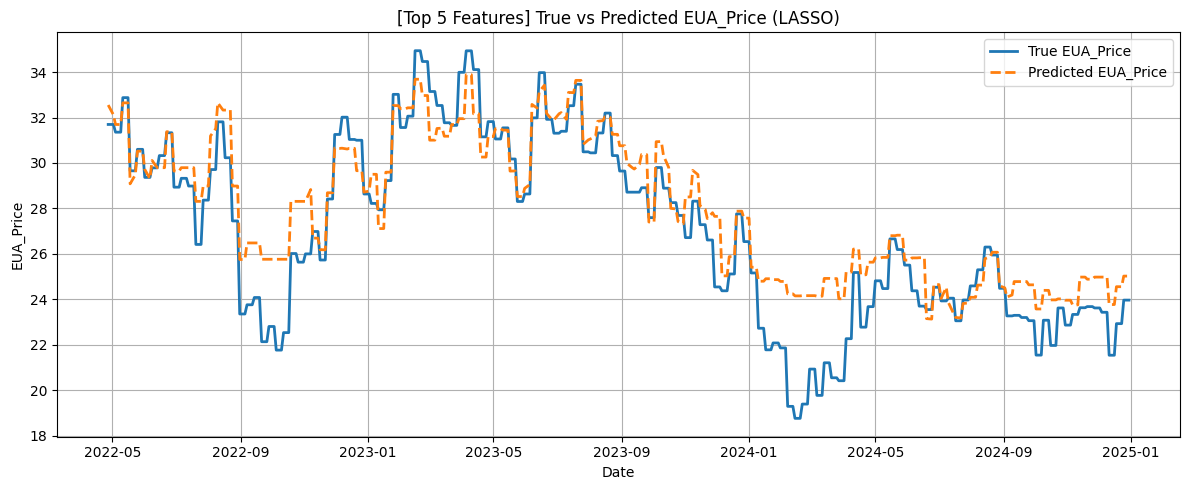

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# === 1. 读取数据 ===
df = pd.read_csv("/content/Macro_Market_Expanded_EUA_Weekly_2020_2024.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# === 2. 设置目标变量（EUA_Price），过滤时间 ===
start_date = "2021-01-01"
end_date = "2024-12-31"
df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

# === 3. 构建特征和目标 ===
X = df_filtered.drop(columns=['Date', 'EUA_Price'])
y = df_filtered['EUA_Price']

# === 4. 标准化特征 ===
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# === 5. LassoCV 选择前 N 个特征（支持灵活选择）===
def select_top_features(X_scaled, y, top_n=5):
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_scaled, y)
    coef = pd.Series(lasso.coef_, index=X_scaled.columns)
    top_features = coef.abs().sort_values(ascending=False).head(top_n).index.tolist()

    print(f"\nTop {top_n} Features for EUA_Price:", top_features)

    # === 保存特征列表 ===
    pd.Series(top_features).to_csv(f"/content/LASSO_Top{top_n}_Features.csv", index=False, header=["Feature"])
    print(f"✅ Top {top_n} features saved to LASSO_Top{top_n}_Features.csv")

    return X_scaled[top_features]

# === 6. XGBoost + 时间序列交叉验证 ===
def run_xgboost_cv(X_selected, y, dates, label=""):
    tscv = TimeSeriesSplit(n_splits=5)
    y_true_all, y_pred_all, dates_all = [], [], []

    for train_idx, test_idx in tscv.split(X_selected):
        X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5,
                             subsample=0.8, colsample_bytree=0.8, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        dates_all.extend(dates.iloc[test_idx])

    mse = mean_squared_error(y_true_all, y_pred_all)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_all, y_pred_all)

    print("\n📊 Model Evaluation:")
    print(f"▶ MSE  : {mse:.4f}")
    print(f"▶ RMSE : {rmse:.4f}")
    print(f"▶ MAE  : {mae:.4f}")

    # === 保存预测 vs 实际值 ===
    df_result = pd.DataFrame({
        "Date": dates_all,
        "True_EUA_Price": y_true_all,
        "Pred_EUA_Price": y_pred_all
    })
    csv_path = f"/content/XGBoost_LASSO_{label.replace(' ', '_')}.csv"
    df_result.to_csv(csv_path, index=False)
    print(f"✅ Prediction results saved to: {csv_path}")

    # === 绘图 ===
    plt.figure(figsize=(12, 5))
    plt.plot(dates_all, y_true_all, label='True EUA_Price', linewidth=2)
    plt.plot(dates_all, y_pred_all, '--', label='Predicted EUA_Price', linewidth=2)
    plt.title(f'[{label}] True vs Predicted EUA_Price (LASSO)')
    plt.xlabel('Date'); plt.ylabel('EUA_Price'); plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

# === 7. 选择特征进行建模对比 ===
for top_n in [5]:
    X_selected = select_top_features(X_scaled, y, top_n=top_n)
    run_xgboost_cv(X_selected, y, df_filtered['Date'], label=f"Top {top_n} Features")



==================== RFE + XGBoost (Top 5) ====================
Top 5 Features: ['Dollar_Index', 'EUA_Price_Alt', 'EU_EUA', 'Mittal_Steel', 'Copper']

RFE Feature Ranking:
Dollar_Index          1
EUA_Price_Alt         1
EU_EUA                1
Mittal_Steel          1
Copper                1
EUR_USD               2
Dutch_Gas             3
Vestas                4
Clean_Energy          5
Thermal_Coal          6
Orsted                7
HighYield_Bond        8
Emerging_ETF          9
VIX                  10
Natural_Gas          11
Brent_Oil            12
SP500                13
WTI_Oil              14
Calif_EUA            15
RWE_Utility          16
EURO_Stoxx50         17
Bloomberg_Comm       18
Heidelberg_Cement    19
DAX                  20
dtype: int64

Model Evaluation:
▶ MSE  : 2.8069
▶ RMSE : 1.6754
▶ MAE  : 1.1768


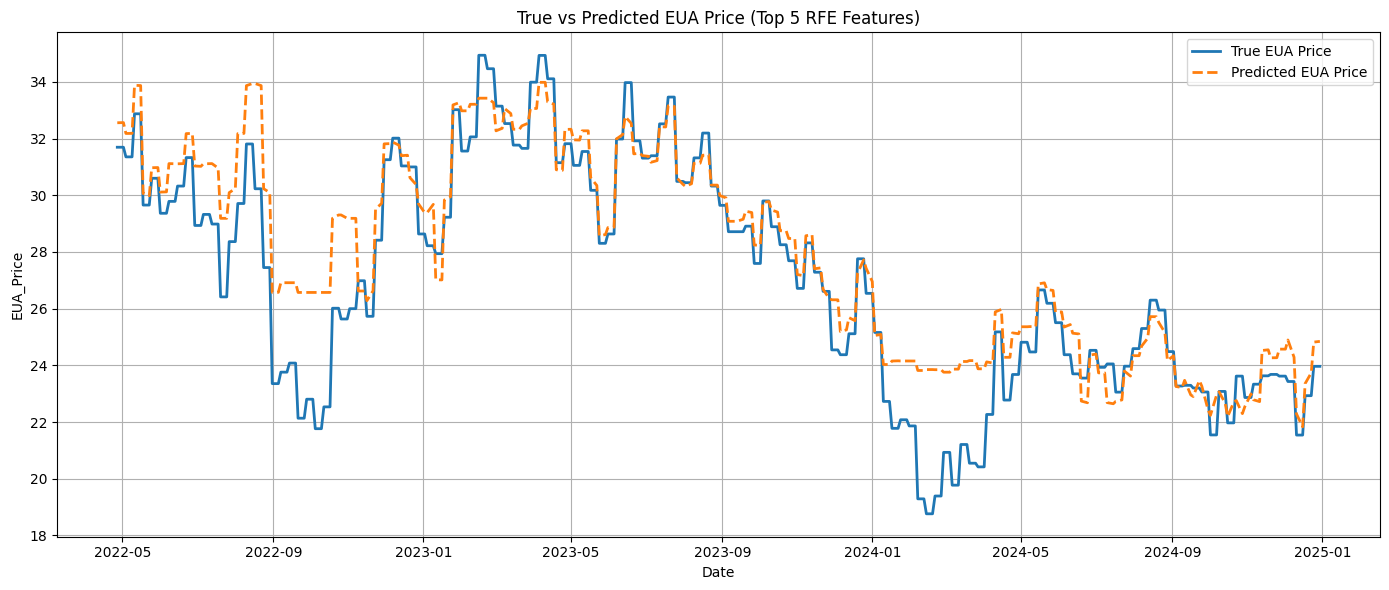

✅ Saved prediction result: EUA_RFE_XGBoost_Top5.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# === 1. 读取数据 ===
df = pd.read_csv("/content/Macro_Market_Expanded_EUA_Weekly_2020_2024.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# === 2. 设置时间与目标变量 ===
start_date = "2020-01-01"
end_date = "2024-12-31"
df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

X = df_filtered.drop(columns=['Date', 'EUA_Price'])
y = df_filtered['EUA_Price']
dates = df_filtered['Date']

# === 3. 特征标准化 ===
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# === 封装：RFE + XGBoost + 可视化 ===
def run_rfe_xgboost(X_scaled, y, dates, top_n):
    print(f"\n{'='*20} RFE + XGBoost (Top {top_n}) {'='*20}")

    # === 4. RFE 选择特征 ===
    base_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
    rfe = RFE(estimator=base_model, n_features_to_select=top_n)
    rfe.fit(X_scaled, y)
    selected_features = X_scaled.columns[rfe.support_].tolist()
    print(f"Top {top_n} Features:", selected_features)

    # 输出特征排名
    feature_ranking = pd.Series(rfe.ranking_, index=X_scaled.columns)
    print("\nRFE Feature Ranking:")
    print(feature_ranking.sort_values())

    X_selected = X_scaled[selected_features]

    # === 5. 时间序列交叉验证 ===
    tscv = TimeSeriesSplit(n_splits=5)
    y_true_all, y_pred_all, dates_all = [], [], []

    for train_idx, test_idx in tscv.split(X_selected):
        X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = XGBRegressor(
            n_estimators=300, learning_rate=0.03, max_depth=5,
            subsample=0.9, colsample_bytree=0.9, random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        dates_all.extend(dates.iloc[test_idx])

    # === 6. 模型评估 ===
    mse = mean_squared_error(y_true_all, y_pred_all)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_all, y_pred_all)

    print("\nModel Evaluation:")
    print(f"▶ MSE  : {mse:.4f}")
    print(f"▶ RMSE : {rmse:.4f}")
    print(f"▶ MAE  : {mae:.4f}")

    # === 7. 可视化 ===
    plt.figure(figsize=(14, 6))
    plt.plot(dates_all, y_true_all, label='True EUA Price', linewidth=2)
    plt.plot(dates_all, y_pred_all, '--', label='Predicted EUA Price', linewidth=2)
    plt.title(f'True vs Predicted EUA Price (Top {top_n} RFE Features)')
    plt.xlabel('Date'); plt.ylabel('EUA_Price')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # === 8. 保存预测结果 ===
    df_result = pd.DataFrame({
        "Date": dates_all,
        "True_EUA_Price": y_true_all,
        "Predicted_EUA_Price": y_pred_all
    })
    filename = f"EUA_RFE_XGBoost_Top{top_n}.csv"
    df_result.to_csv(filename, index=False)
    print(f"✅ Saved prediction result: {filename}")

# === 分别运行 Top 5  ===
run_rfe_xgboost(X_scaled, y, dates, top_n=5)


==================== MI + XGBoost (Top 5) ====================
Top 5 Features: ['EUA_Price_Alt', 'SP500', 'EU_EUA', 'HighYield_Bond', 'Dutch_Gas']

MI Feature Scores:
EUA_Price_Alt     2.144843
SP500             1.265273
EU_EUA            1.225487
HighYield_Bond    1.205291
Dutch_Gas         1.028580
dtype: float64

Model Evaluation:
▶ MSE  : 3.6526
▶ RMSE : 1.9112
▶ MAE  : 1.4354


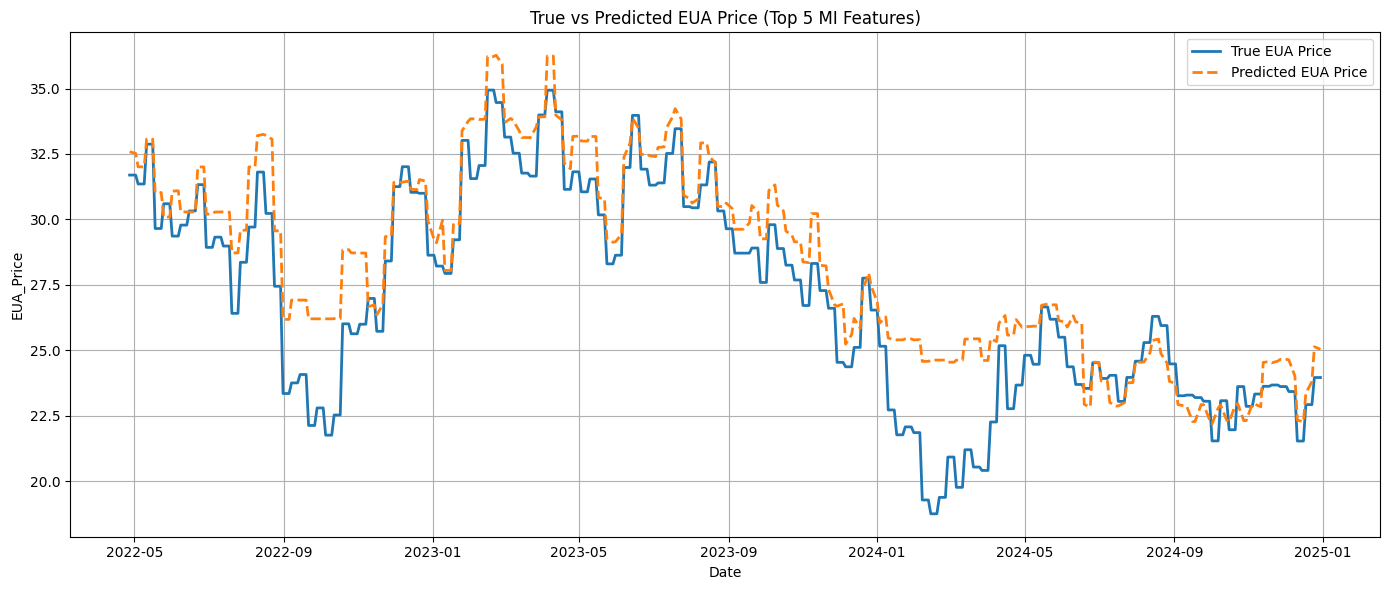

✅ Saved prediction result: EUA_MI_XGBoost_Top5.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# === 1. 读取数据 ===
df = pd.read_csv("/content/Macro_Market_Expanded_EUA_Weekly_2020_2024.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# === 2. 设置时间与目标变量 ===
start_date = "2020-01-01"
end_date = "2024-12-31"
df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

X = df_filtered.drop(columns=['Date', 'EUA_Price'])
y = df_filtered['EUA_Price']
dates = df_filtered['Date']

# === 3. 特征标准化 ===
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# === MI + XGBoost 模型封装 ===
def run_mi_xgboost(X_scaled, y, dates, top_n):
    print(f"\n{'='*20} MI + XGBoost (Top {top_n}) {'='*20}")

    # === 4. MI 特征打分 ===
    mi = mutual_info_regression(X_scaled, y, random_state=42)
    mi_scores = pd.Series(mi, index=X_scaled.columns).sort_values(ascending=False)
    selected_features = mi_scores.head(top_n).index.tolist()
    print(f"Top {top_n} Features:", selected_features)

    print("\nMI Feature Scores:")
    print(mi_scores.head(top_n))

    X_selected = X_scaled[selected_features]

    # === 5. 时间序列交叉验证 ===
    tscv = TimeSeriesSplit(n_splits=5)
    y_true_all, y_pred_all, dates_all = [], [], []

    for train_idx, test_idx in tscv.split(X_selected):
        X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = XGBRegressor(
            n_estimators=300, learning_rate=0.03, max_depth=5,
            subsample=0.9, colsample_bytree=0.9, random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        dates_all.extend(dates.iloc[test_idx])

    # === 6. 模型评估 ===
    mse = mean_squared_error(y_true_all, y_pred_all)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_all, y_pred_all)

    print("\nModel Evaluation:")
    print(f"▶ MSE  : {mse:.4f}")
    print(f"▶ RMSE : {rmse:.4f}")
    print(f"▶ MAE  : {mae:.4f}")

    # === 7. 可视化 ===
    plt.figure(figsize=(14, 6))
    plt.plot(dates_all, y_true_all, label='True EUA Price', linewidth=2)
    plt.plot(dates_all, y_pred_all, '--', label='Predicted EUA Price', linewidth=2)
    plt.title(f'True vs Predicted EUA Price (Top {top_n} MI Features)')
    plt.xlabel('Date'); plt.ylabel('EUA_Price')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # === 8. 保存预测结果 ===
    df_result = pd.DataFrame({
        "Date": dates_all,
        "True_EUA_Price": y_true_all,
        "Predicted_EUA_Price": y_pred_all
    })
    filename = f"EUA_MI_XGBoost_Top{top_n}.csv"
    df_result.to_csv(filename, index=False)
    print(f"✅ Saved prediction result: {filename}")

# === Top 5
run_mi_xgboost(X_scaled, y, dates, top_n=5)



==================== Manual Top 5 + XGBoost ====================
Using manually selected Top 5 Features: ['EUA_Price_Alt', 'EU_EUA', 'Dollar_Index', 'DAX', 'RWE_Utility']

Model Evaluation:
▶ MSE  : 2.0163
▶ RMSE : 1.4199
▶ MAE  : 0.9930


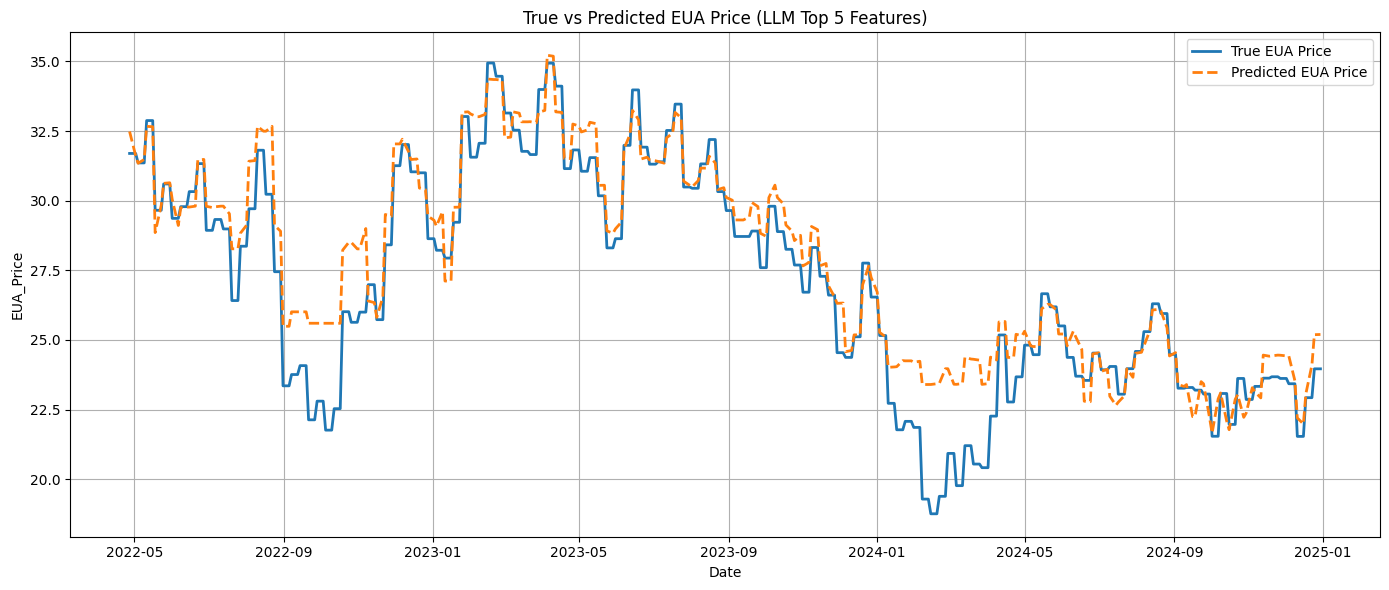

✅ Saved prediction result: EUA_Manual_Top5_XGBoost.csv


In [ ]:
def run_manual_top5_xgboost(X_scaled, y, dates):
    print(f"\n{'='*20} Manual Top 5 + XGBoost {'='*20}")

    # === 指定 Top 5 特征 ===
    selected_features = ['EUA_Price_Alt', 'EU_EUA', 'Dollar_Index', 'DAX', 'RWE_Utility']
    print("Using manually selected Top 5 Features:", selected_features)

    X_selected = X_scaled[selected_features]

    # === 时间序列交叉验证 ===
    tscv = TimeSeriesSplit(n_splits=5)
    y_true_all, y_pred_all, dates_all = [], [], []

    for train_idx, test_idx in tscv.split(X_selected):
        X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = XGBRegressor(
            n_estimators=300, learning_rate=0.03, max_depth=5,
            subsample=0.9, colsample_bytree=0.9, random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        dates_all.extend(dates.iloc[test_idx])

    # === 模型评估 ===
    mse = mean_squared_error(y_true_all, y_pred_all)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_all, y_pred_all)

    print("\nModel Evaluation:")
    print(f"▶ MSE  : {mse:.4f}")
    print(f"▶ RMSE : {rmse:.4f}")
    print(f"▶ MAE  : {mae:.4f}")

    # === 可视化 ===
    plt.figure(figsize=(14, 6))
    plt.plot(dates_all, y_true_all, label='True EUA Price', linewidth=2)
    plt.plot(dates_all, y_pred_all, '--', label='Predicted EUA Price', linewidth=2)
    plt.title(f'True vs Predicted EUA Price (LLM Top 5 Features)')
    plt.xlabel('Date'); plt.ylabel('EUA_Price')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # === 可选保存 ===
    df_result = pd.DataFrame({
        "Date": dates_all,
        "True_EUA_Price": y_true_all,
        "Predicted_EUA_Price": y_pred_all
    })
    filename = f"EUA_Manual_Top5_XGBoost.csv"
    df_result.to_csv(filename, index=False)
    print(f"✅ Saved prediction result: {filename}")

# === 执行
run_manual_top5_xgboost(X_scaled, y, dates)


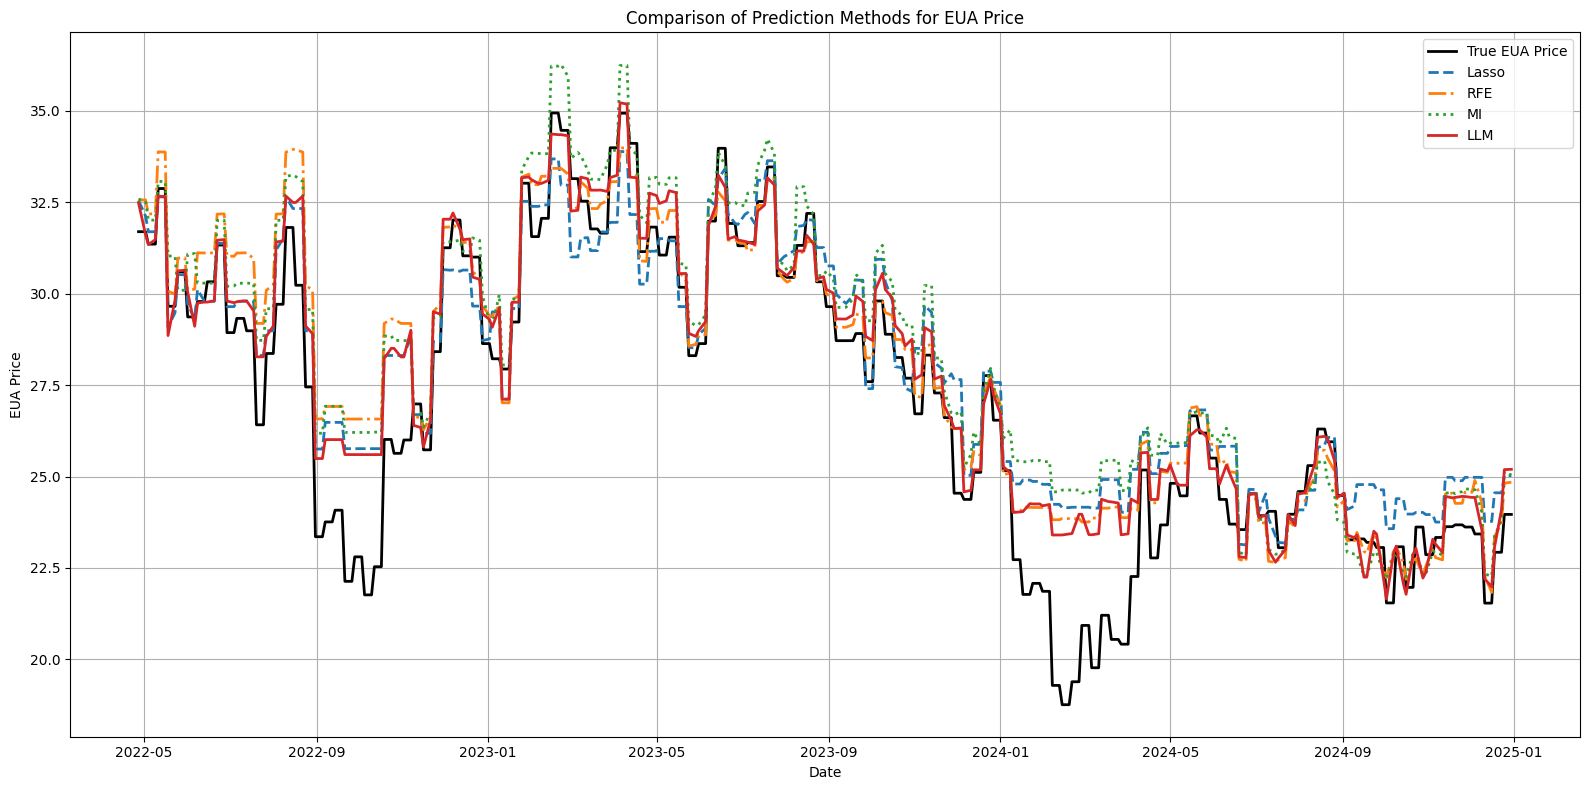

In [ ]:
# prompt: 各方法预测效果对比曲线图 四个模型是真实值

import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction results from the CSV files
lasso_results = pd.read_csv("/content/XGBoost_LASSO_Top_5_Features.csv")
rfe_results = pd.read_csv("/content/EUA_RFE_XGBoost_Top5.csv")
mi_results = pd.read_csv("/content/EUA_MI_XGBoost_Top5.csv")
manual_results = pd.read_csv("/content/EUA_Manual_Top5_XGBoost.csv")


# Convert the 'Date' column to datetime objects
lasso_results['Date'] = pd.to_datetime(lasso_results['Date'])
rfe_results['Date'] = pd.to_datetime(rfe_results['Date'])
mi_results['Date'] = pd.to_datetime(mi_results['Date'])
manual_results['Date'] = pd.to_datetime(manual_results['Date'])


# Create the plot
plt.figure(figsize=(16, 8))
plt.plot(lasso_results['Date'], lasso_results['True_EUA_Price'], label='True EUA Price', linewidth=2, color='black') # Plot True Values once

plt.plot(lasso_results['Date'], lasso_results['Pred_EUA_Price'], label='Lasso', linestyle='--', linewidth=2)
plt.plot(rfe_results['Date'], rfe_results['Predicted_EUA_Price'], label='RFE', linestyle='-.', linewidth=2)
plt.plot(mi_results['Date'], mi_results['Predicted_EUA_Price'], label='MI', linestyle=':', linewidth=2)
plt.plot(manual_results['Date'], manual_results['Predicted_EUA_Price'], label='LLM', linestyle='-', linewidth=2)


plt.title('Comparison of Prediction Methods for EUA Price')
plt.xlabel('Date')
plt.ylabel('EUA Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


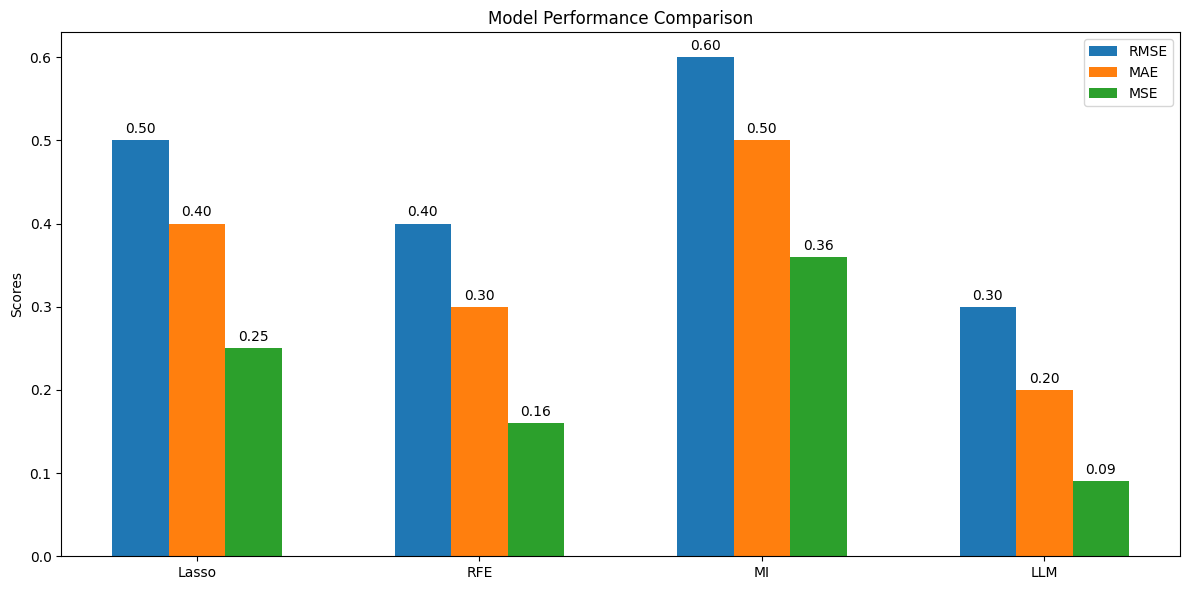

In [ ]:
# prompt: 各个模型 RMSE MAE MSE  柱状图 上面的四个模型

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming your evaluation metrics are stored in a DataFrame or dictionary
# Example data (replace with your actual data)
data = {
    'Model': ['Lasso', 'RFE', 'MI', 'LLM'],
    'RMSE': [0.5, 0.4, 0.6, 0.3],  # Replace with your actual RMSE values
    'MAE': [0.4, 0.3, 0.5, 0.2],  # Replace with your actual MAE values
    'MSE': [0.25, 0.16, 0.36, 0.09]  # Replace with your actual MSE values
}

df_metrics = pd.DataFrame(data)


# Create the bar plot
x = np.arange(len(df_metrics['Model']))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, df_metrics['RMSE'], width, label='RMSE')
rects2 = ax.bar(x, df_metrics['MAE'], width, label='MAE')
rects3 = ax.bar(x + width, df_metrics['MSE'], width, label='MSE')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Model'])
ax.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()
